In [2]:
#Data manipulation related
import pandas as pd
import numpy as np
#Plotting imports
import seaborn as sns
import matplotlib.pyplot as plt

#Python
import requests as req
import time
import spacy as sp
from collections import OrderedDict
from operator import itemgetter
import regex as reg

#All sklearn imports
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, f1_score

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

In [3]:
#65 days of posts from one subreddit and 45 day from another to ensure an un-even spread vs 50/50 spread
til  = pd.read_csv('./reddit_65days.csv')
moto = pd.read_csv('./reddit_45_m_days.csv')

In [4]:
til['subreddit'] = til['subreddit'].map({'motorcycles':1,'todayilearned':0})
til['selftext'] = np.where(til['selftext'].isna(),'',til['selftext'])
til['selftext'] = np.where( (til['selftext'] == '[removed]'),'',til['selftext'])
til['selftext'] = np.where( (til['selftext'] == '[deleted]'),'',til['selftext'])
til['combinedtext'] = til['title'] + ' ' + til['selftext']
til = til[['combinedtext','subreddit']]

moto['subreddit'] = moto['subreddit'].map({'motorcycles':1,'todayilearned':0})
moto['selftext'] = np.where(moto['selftext'].isna(),'',moto['selftext'])
moto['selftext'] = np.where( (moto['selftext'] == '[removed]'),'',moto['selftext'])
moto['selftext'] = np.where( (moto['selftext'] == '[deleted]'),'',moto['selftext'])
moto['combinedtext'] = moto['title'] + ' ' + moto['selftext']

moto = moto[['combinedtext','subreddit']]


In [5]:
redditdf = til.merge(moto, on = ['combinedtext','subreddit'], how = 'outer')

redditdf.head()
redditdf.isna().sum()
redditdf.info()

,combinedtext,subreddit
0,TIL that between 76 and 92% of Americans males...,0
1,TIL that between 76 and 92% of Americans males...,0
2,TIL that 81% of American males (aged 14-59) ar...,0
3,TIL that 81% of American males (aged 14-59) ar...,0
4,TIL that the owo_bot account is rated more who...,0


combinedtext    0
subreddit       0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54612 entries, 0 to 54611
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   combinedtext  54612 non-null  object
 1   subreddit     54612 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.2+ MB


In [6]:
y = redditdf['subreddit']
X = redditdf['combinedtext']

X.shape
y.shape

(54612,)

(54612,)

In [7]:
y.value_counts()
y.value_counts(normalize = True)

0    32437
1    22175
Name: subreddit, dtype: int64

0    0.593954
1    0.406046
Name: subreddit, dtype: float64

##### Split data into training and test sets.

In [8]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.33,random_state = 111)
X_train.shape
X_test.shape
y_test.shape
y_train.shape

(36590,)

(18022,)

(18022,)

(36590,)

In [9]:
y_train.value_counts()
y_train.value_counts(normalize = True)

0    21716
1    14874
Name: subreddit, dtype: int64

0    0.593495
1    0.406505
Name: subreddit, dtype: float64

In [10]:
y_test.value_counts()
y_test.value_counts(normalize = True)

0    10721
1     7301
Name: subreddit, dtype: int64

0    0.594884
1    0.405116
Name: subreddit, dtype: float64

##### Use spaCy NLP library to tokenize and lemmatize each document

In [14]:
def lemma_tokens(doc):
    d = spacy_nlp(doc)
    return [token.lemma_ for token in d if not token.is_stop \
           and token.is_alpha and token.lemma_ != '-PRON-']

##### This function pre-processes text. Specifically uses a regex to remove punctuation, urls, line feed, tab spaces, carriage returns
##### Also removes 'TIL' from each document. Every 'todayilearned' sub-reddit post begins with TIL.

In [15]:
spacy_stopwords = sp.lang.en.stop_words.STOP_WORDS

#print(spacy_stopwords)
common_words = []

def clean_text(text):

#replace anything that isn't a-z or A-Z with spaces including punctuations, exclamation etc
#replace 'https://', 'www.' by space 
    ret_str = ' '
    regex = r"(.\\n|.\\t|.\\r)|(^TIL)|([^a-zA-Z0-9\s]+)|(ht[tp?s://a-zA-Z0-9.com]+)|(ww[wa-zA-Z0-9.com]+)"
    ret_str = reg.sub(regex, '', text)
    ret_str = ret_str.rstrip() 
    ret_str = ret_str.lstrip()
    ret_str = ret_str.lower()
    doc = spacy_nlp(ret_str)
    all_lemmas =  [token.lemma_ for token in doc if  not token.is_stop \
                   and token.is_alpha and token.lemma_ != '-PRON-']
    #word_count = Counter(words)
    #common_words = word_count.most_common(5)
    #common_words.append (word_count.most_common(5))
    return(" ".join(all_lemmas)) 


AttributeError: module 'spacy' has no attribute 'lang'

#### Iterate over each document in X and pre-processes it.

In [16]:
## Clean data. 
## See clean_text() above for details.
def process_text():
    X_clean_train = []
    X_clean_test = []
    start = time.perf_counter()
    counter = 0

    for train in X_train:
        X_clean_train.append(clean_text(train))
        counter += 1
    print(f"Processed {counter} rows in training data")

    counter = 0
    for test in X_test:
            X_clean_test.append(clean_text(test))
            counter += 1
    print(f"Processed {counter} rows in test data")

    end = time.perf_counter()

    print(f"Took { round((end-start)/60,0)} minutes to clean,tokenize and lemmatize")
    return X_clean_train,X_clean_test


In [17]:
X_clean_train,X_clean_test  = process_text()

NameError: name 'clean_text' is not defined

##### Vectorize pre-processed X using CountVectorizer

In [17]:
#Convert X_clean_train, X_clean_test to matrix of token counts

count_vectorizer = CountVectorizer()
X_clean_train_matrix = count_vectorizer.fit_transform(X_clean_train)
X_clean_test_matrix = count_vectorizer.transform(X_clean_test)

X_clean_train_df = pd.DataFrame(X_clean_train_matrix.toarray())
X_clean_train_df.head()

X_clean_test_df = pd.DataFrame(X_clean_test_matrix.toarray())
X_clean_test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,32162,32163,32164,32165,32166,32167,32168,32169,32170,32171
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,0,1,2,3,4,5,6,7,8,9,...,32162,32163,32164,32165,32166,32167,32168,32169,32170,32171
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#####  Count of most frequent words in pre-processed X 

In [30]:
def word_frequency(dataset):

    word_freq = {}
    upper_limit = 0
    
    for s in dataset:
        string = s.split(' ')
        for w in string:
            if word_freq.get(w):
                word_freq[w] += 1
            else:
                word_freq[w] = 1

    #sort the word_freq dictionary in descending order            
    orderd_dict = OrderedDict(sorted(word_freq.items(), key=itemgetter(1), reverse = True))

    words =[]
    freq = []
    count = 0
    if dataset == X_clean_train:
        upper_limit = 1500
    else:
        upper_limit = 800
    #only most frequent words else we will get a pretty long list of words
    for k,v in orderd_dict.items():
        if v > upper_limit:
            words.append(k)
            freq.append(v)
    return words, freq

##### Plot most common words in X 

In [31]:
def plot_words(x,y,color,title):
    
    plt.figure(figsize = (17,8))
    plt.style.use('fivethirtyeight')
    plt.xlabel('Words', {'fontsize': 14})
    plt.ylabel('Count',{'fontsize': 14})
    plt.xticks(fontsize = 14, rotation = 'vertical')
    plt.title('Top words in ' + title , fontsize = 16)
    plt.bar(x,y, color = color)

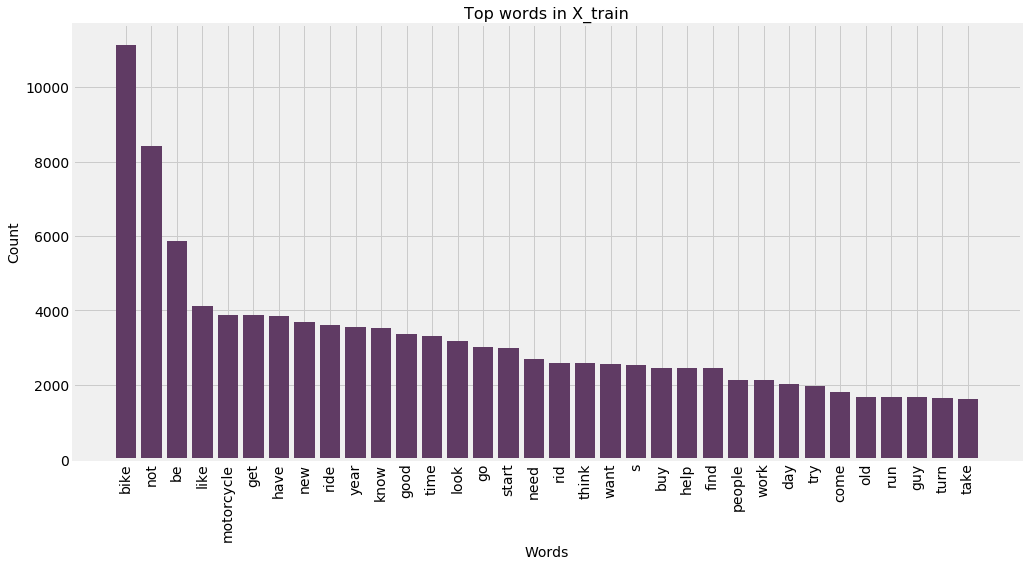

In [32]:
train_words, train_freq = word_frequency(X_clean_train)
plot_words(train_words,train_freq,'#603b64','X_train')

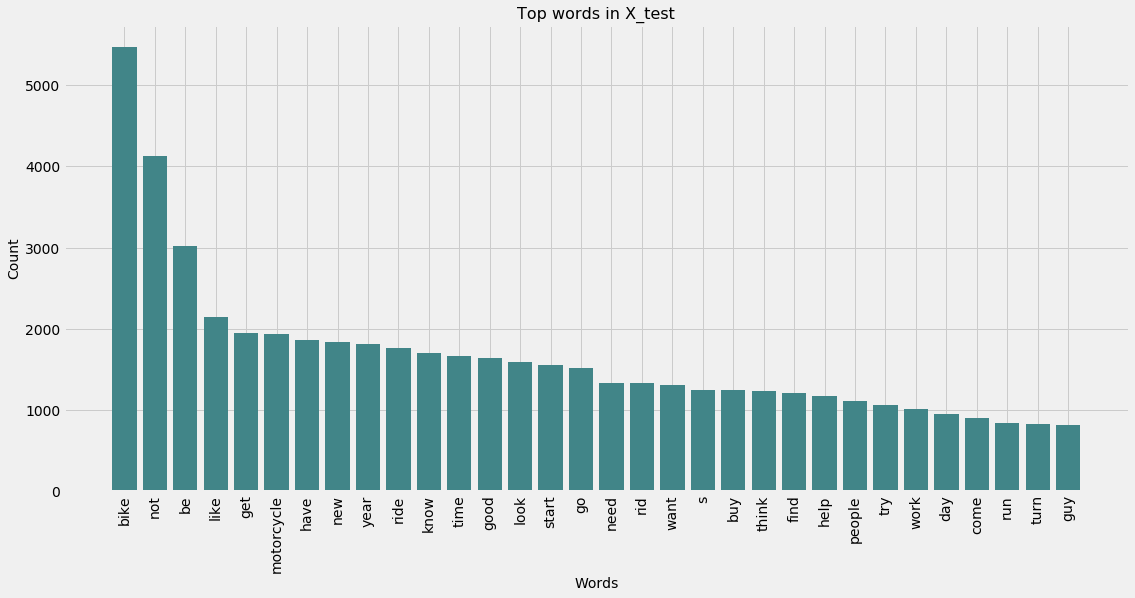

In [33]:
test_words, test_freq = word_frequency(X_clean_test)
plot_words(test_words,test_freq,'#418588','X_test')

###### Common functions to fit a model, extract confusion matrix, plot confusion matrix and plot CV mean test scores for each fold

In [36]:
## Save all the cv_results matrices and grid search objects for each call. Can access them
## rather than having to run grid search again as that can take a lot of time.

list_of_grid_search_objects = []
list_of_cvresults = []

In [37]:
def plot_cv_results(xval,yval):
    
    plt.figure(figsize = (17,8))
    plt.style.use('seaborn-whitegrid')
    sns.swarmplot(xval,yval,size = 8.0)
    plt.xlabel('Max features')
    plt.ylabel('Mean test score')
    plt.show();

In [38]:
def plot_conf_matrix(matrix,cmap):
    _ = sns.heatmap(confu_matrix,annot = True, fmt = 'd', cbar = False, cmap = cmap);
    plt.show()

In [39]:
def conf_matrix(gsobject,xdata,ydata):
    predicted = gsobject.predict(xdata)
    actual_predicted = pd.DataFrame({"Actual" : ydata, "Predicted": predicted, 'Text': xdata})
    cmatrix = confusion_matrix(ydata,predicted).ravel()
    
    c_matrix =  pd.DataFrame(cmatrix.reshape(2,2),
                        index = ['Actual TIL','Actual Motorcyle'],
                        columns= ['Predicted TIL','Predicted Motorcyles'])
    return actual_predicted,c_matrix

In [40]:
#gs_type = grid search object
#xtraindata,xtestdata = xtrain and xtest 
#ytraindata,ytest = ytrain and ytest
def fit_grid_search(gs_type,xtraindata,ytraindata,xtestdata,ytestdata):
    start = time.perf_counter()
    gs_type.fit(xtraindata,ytraindata)
    print(f"Grid search accuracy for estimator \033[1m{gs_type.estimator.steps[1][0]}\033[0m "
          f"transformer \033[1m{gs_type.estimator.steps[0][0]}\033[0m : \n")
    print(f"On training data is {gs_type.score(xtraindata,ytraindata)}")
    print(f"On test data is {gs_type.score(xtestdata,ytestdata)}")
    print(f"Grid search best score (avg of cv scores) {gs_type.best_score_}\n\n")
    print(f"Model with best fitting parameter is \n {gs_type.best_estimator_.get_params}\n\n")
    #print(gs_type.best_estimator_.named_steps['logisticregression'].coef_)
    end = time.perf_counter()
    print(f"Took \033[1m{ round((end-start)/60,0)}\033[0m minutes to complete")
    cv_results_df = pd.DataFrame(gs_type.cv_results_)
    list_of_grid_search_objects.append(gs_type)
    list_of_cvresults.append(cv_results_df)
    return cv_results_df,gs_type

### Build a LogisticRegression model with raw text using both CountVectorizer and TfidfVectorizer defaults

In [41]:
pipette_tfidf = make_pipeline(TfidfVectorizer(),LogisticRegression())
pipe_params_tfidf = {
    'tfidfvectorizer__max_features': [30_000,40_000,50_000],
    'tfidfvectorizer__ngram_range': [ (1,2),(1,3)],
    'tfidfvectorizer__min_df' : [5,10], #discard words that appear in less than 2 or 5 documents
    'tfidfvectorizer__max_df' : [0.80], #exclude words that cross this threshold(how many documents contained a term)
    'tfidfvectorizer__stop_words' : ['english',None],
    'logisticregression__max_iter': [600]
}

In [42]:
gs_tfidf = GridSearchCV(pipette_tfidf, 
                  pipe_params_tfidf, 
                  cv = 5 ,
                  verbose = 1)

In [43]:
results_tfidf,gs_tfidf_ = fit_grid_search(gs_tfidf,X_train,y_train,X_test,y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.9min finished


Grid search accuracy for estimator logisticregression transformer tfidfvectorizer : 

On training data is 0.991445750204974
On test data is 0.9867384308067917
Grid search best score (avg of cv scores) 0.983930035528833


Model with best fitting parameter is 
 <bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.8, max_features=40000,
                                 min_df=5, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern

In [51]:
#coef = gs_tfidf_.best_estimator_.named_steps['logisticregression'].coef_

Training set confusion matrix


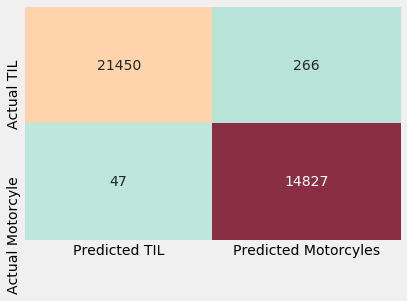

Testing set confusion matrix


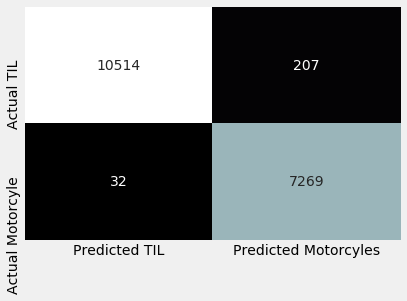

In [53]:
print(f"\033[1mTraining set confusion matrix\033[0m")
actual_v_predicted_train, confu_matrix = conf_matrix(gs_tfidf_,X_train,y_train)
plot_conf_matrix(confu_matrix,'icefire')

print(f"\033[1mTesting set confusion matrix\033[0m")
actual_v_predicted_test,confu_matrix = conf_matrix(gs_tfidf_,X_test,y_test)
plot_conf_matrix(confu_matrix,'bone')

print(classification_report(y_train, gs_tfidf_.predict(X_train),
                    target_names=["Motorcye", "Not Motorcycle"]))

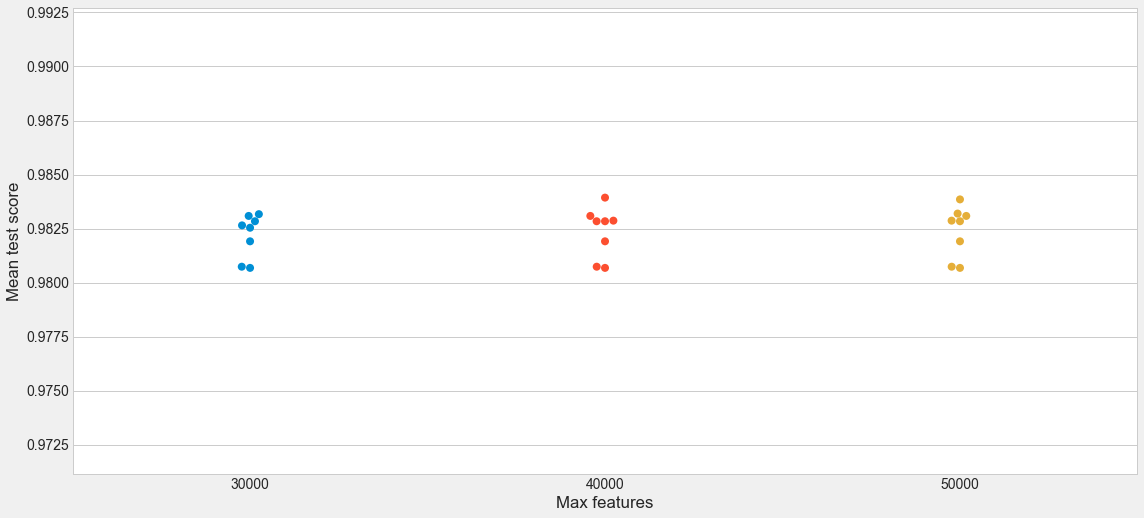

In [54]:
plot_cv_results(results_tfidf.param_tfidfvectorizer__max_features,results_tfidf.mean_test_score)

In [55]:
actual_v_predicted_train.head()
actual_v_predicted_test.head()

,Actual,Predicted,Text
54421,1,1,Royal Jordanian Goes To The Cinema - Portrait ...
41640,1,1,"Probably goes without saying but, remember not..."
2881,0,0,Streetbillionairementor.com visit and save up ...
26213,0,0,TIL two men with Aspergers started a successfu...
12355,0,0,TIL about WWII wooden-hauled devil boats. Thes...


,Actual,Predicted,Text
16124,0,0,TIL wheezing sounds like a whale under a steth...
54488,1,0,I’m begging that someone can make it clear to ...
54277,1,1,Places to try on boots around Orange County? T...
2395,0,0,"TIL Our Sun has ""Sunquakes"" generating waves r..."
28871,0,0,TIL if the salt in the ocean could be removed ...


In [56]:
pipette_cvect = make_pipeline(CountVectorizer(),LogisticRegression())
pipe_params_cvect = {
    'countvectorizer__max_features': [3_000,4_000,5_000],
    'countvectorizer__ngram_range': [(1,3),(1,2)],
    'countvectorizer__min_df' : [10], #discard words that appear in less than 2 or 5 documents
    'countvectorizer__max_df' : [0.7,0.9], #exclude words that cross this threshold(how many docs contained a term)
    'countvectorizer__stop_words' : ['english',None],
    'logisticregression__max_iter': [600]
}

In [57]:
gs_cvect = GridSearchCV(pipette_cvect, 
                  pipe_params_cvect, 
                  cv = 5,
                  verbose = 1)

In [58]:
results_cvect,gs_cvect_ = fit_grid_search(gs_cvect,X_train,y_train,X_test,y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  7.9min finished


Grid search accuracy for estimator logisticregression transformer countvectorizer : 

On training data is 0.9912271112325772
On test data is 0.9839640439462879
Grid search best score (avg of cv scores) 0.9808144301721782


Model with best fitting parameter is 
 <bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.7,
                                 max_features=5000, min_df=10,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('logist

Training set confusion matrix


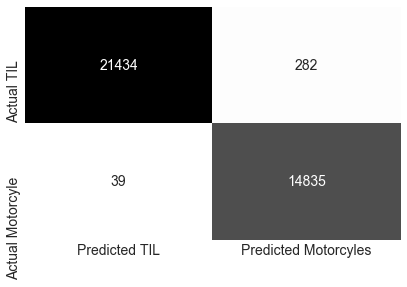

Testing set confusion matrix


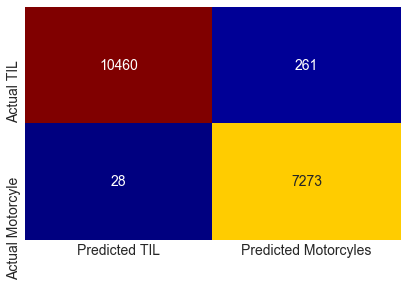

In [59]:
print(f"\033[1mTraining set confusion matrix\033[0m")
actual_v_predicted_train, confu_matrix = conf_matrix(gs_cvect_,X_train,y_train)
plot_conf_matrix(confu_matrix,'binary')

print(f"\033[1mTesting set confusion matrix\033[0m")
actual_v_predicted_test,confu_matrix = conf_matrix(gs_cvect_,X_test,y_test)
plot_conf_matrix(confu_matrix,'jet')

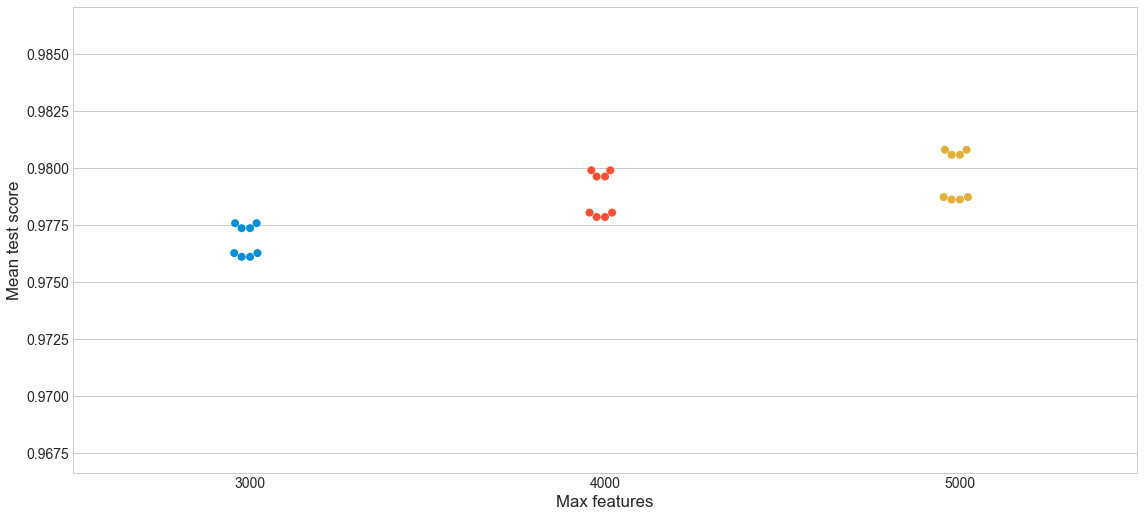

In [60]:
plot_cv_results(results_cvect.param_countvectorizer__max_features,results_cvect.mean_test_score)

### Build a LogisticRegression model on processed data using both CountVectorizer and TfidfVectorizer on pre-processed data


In [61]:
pipette_tfidf = make_pipeline(TfidfVectorizer(),LogisticRegression())
pipe_params_tfidf = {
    'tfidfvectorizer__max_features': [30_00,4_000,5_000],
    'tfidfvectorizer__ngram_range': [ (1,2),(1,3) ],
    'tfidfvectorizer__min_df' : [5,10], #discard words that appear in less than 5 or 10 documents
    'tfidfvectorizer__max_df' : [0.6,0.8],#exclude words that cross this threshold(how many docs contained a term)
    'tfidfvectorizer__stop_words' : [None],
    'logisticregression__max_iter': [600]
}

In [62]:
gs_tfidf = GridSearchCV(pipette_tfidf, 
                  pipe_params_tfidf, 
                  cv = 5,
                  verbose = 1)

In [63]:
results_tfidf_,gs_tfidf_ = fit_grid_search(gs_tfidf,X_clean_train,y_train,X_clean_test,y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  4.6min finished


Grid search accuracy for estimator logisticregression transformer tfidfvectorizer : 

On training data is 0.9711396556436185
On test data is 0.9641549217622906
Grid search best score (avg of cv scores) 0.960481005739273


Model with best fitting parameter is 
 <bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.6, max_features=5000,
                                 min_df=10, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 token_patter

Training set confusion matrix


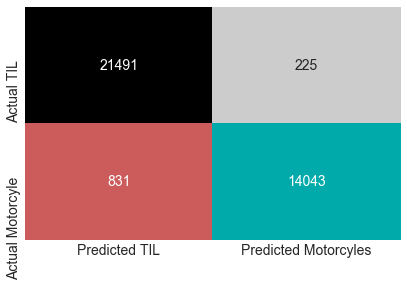

Testing set confusion matrix


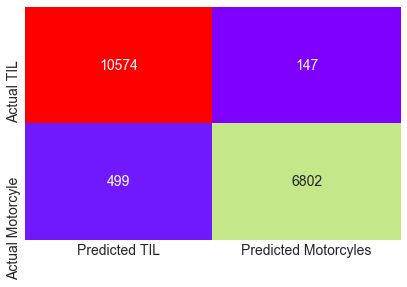

In [64]:
print(f"\033[1mTraining set confusion matrix\033[0m")
actual_v_predicted_train, confu_matrix = conf_matrix(gs_tfidf_,X_clean_train,y_train)
plot_conf_matrix(confu_matrix, 'nipy_spectral_r');

print(f"\033[1mTesting set confusion matrix\033[0m")
actual_v_predicted_test,confu_matrix = conf_matrix(gs_tfidf_,X_clean_test,y_test)
plot_conf_matrix(confu_matrix,'rainbow');


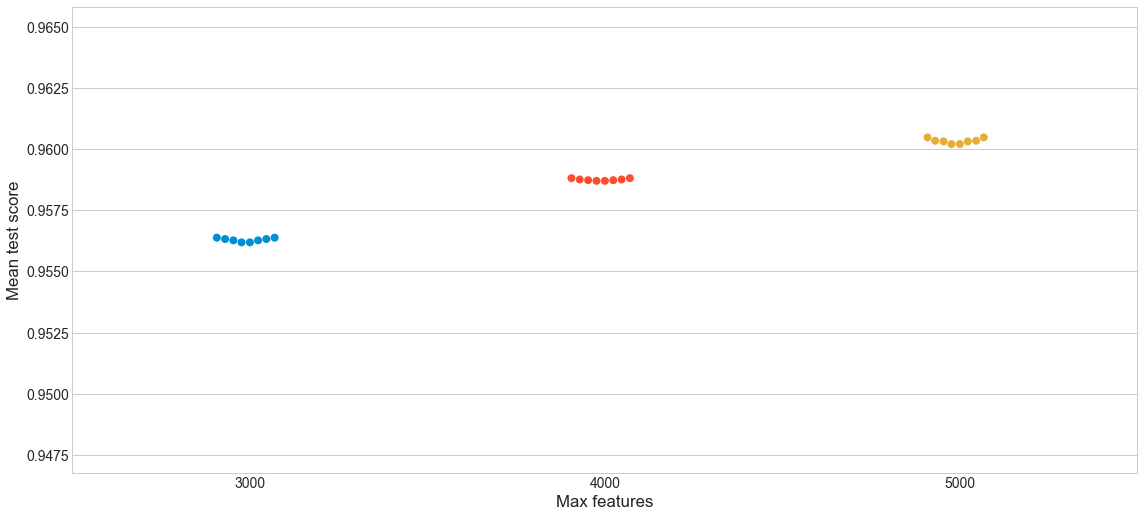

In [65]:
plot_cv_results(results_tfidf_.param_tfidfvectorizer__max_features,results_tfidf_.mean_test_score)

In [66]:
pipette_cvect = make_pipeline(CountVectorizer(),LogisticRegression())
pipe_params_cvect = {
    'countvectorizer__max_features': [25_000,35_000,50_000],
    'countvectorizer__ngram_range': [(1,2),(1,3)], #discard words that appear in less than 5 or 10 documents
    'countvectorizer__min_df' : [5, 10], #exclude words that cross this threshold(how many docs contained a term)
    'countvectorizer__max_df' : [0.85, 0.95],
    'countvectorizer__stop_words' : [None],
    'logisticregression__max_iter': [600]
}

In [67]:
gs_cvect = GridSearchCV(pipette_cvect, 
                  pipe_params_cvect, 
                  cv = 5,
                  verbose = 1)

In [68]:
results_cvect_,gs_cvect_ = fit_grid_search(gs_cvect,X_clean_train,y_train,X_clean_test,y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  5.0min finished


Grid search accuracy for estimator logisticregression transformer countvectorizer : 

On training data is 0.9899426072697458
On test data is 0.982632338253246
Grid search best score (avg of cv scores) 0.9768515987974856


Model with best fitting parameter is 
 <bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.85,
                                 max_features=50000, min_df=5,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('logist

Training set confusion matrix


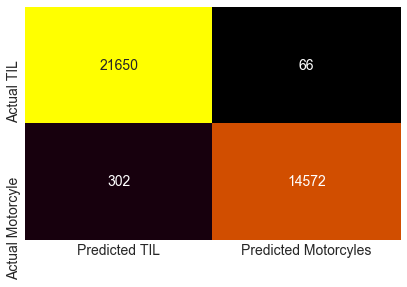

Testing set confusion matrix


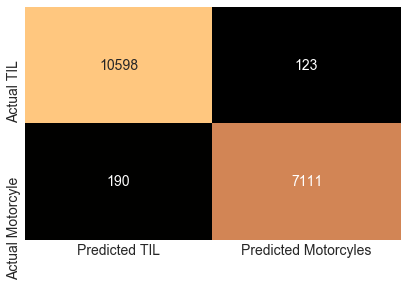

In [69]:
print(f"\033[1mTraining set confusion matrix\033[0m")
actual_v_predicted_train, confu_matrix = conf_matrix(gs_cvect_,X_clean_train,y_train)
plot_conf_matrix(confu_matrix,cmap = 'gnuplot');

print(f"\033[1mTesting set confusion matrix\033[0m")
actual_v_predicted_test,confu_matrix = conf_matrix(gs_cvect_,X_clean_test,y_test)
plot_conf_matrix(confu_matrix,'copper');

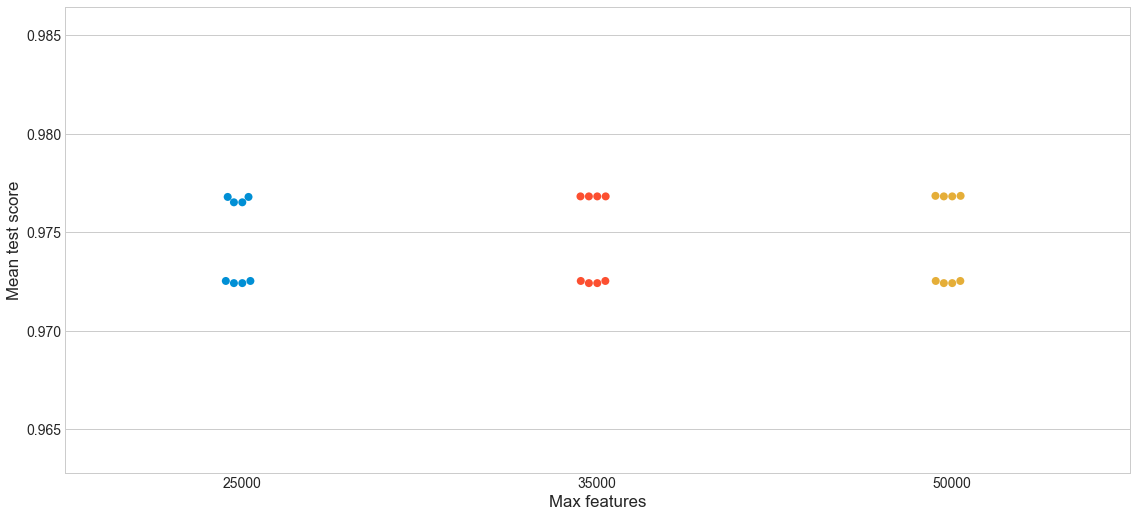

In [70]:
plot_cv_results(results_cvect_.param_countvectorizer__max_features,results_cvect_.mean_test_score)

#### MultinomialNB model using CoutVectorizer and TfidfVectorizer on processed data using defaults

In [72]:
pipette_cvect_mn = make_pipeline(CountVectorizer(),MultinomialNB())

pipe_params_cvect_mn = {
    'countvectorizer__max_features': [20_000,35_000,45_000],
    'countvectorizer__ngram_range': [(1,2),(1,3)],
    'countvectorizer__min_df' : [5, 10],
    'countvectorizer__max_df' : [0.85, 0.95],
    'countvectorizer__stop_words' : [None],
    'multinomialnb__alpha': [1]
}

gs_cvect_mn = GridSearchCV(pipette_cvect_mn,
                          pipe_params_cvect_mn,
                          cv = 5, verbose = 1)

results_cvect_mn,gs_cvect_mn = fit_grid_search(gs_cvect_mn,X_clean_train,y_train,X_clean_test,y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  4.3min finished


Grid search accuracy for estimator multinomialnb transformer countvectorizer : 

On training data is 0.9650177644165072
On test data is 0.9597713905226944
Grid search best score (avg of cv scores) 0.9571194315386717


Model with best fitting parameter is 
 <bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('countvectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.85,
                                 max_features=45000, min_df=5,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('multinomia

Training set confusion matrix


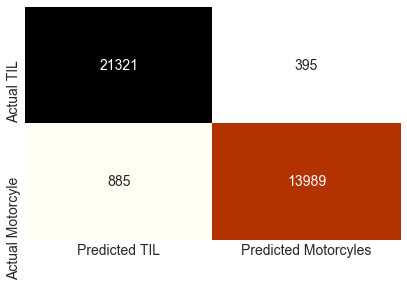

Testing set confusion matrix


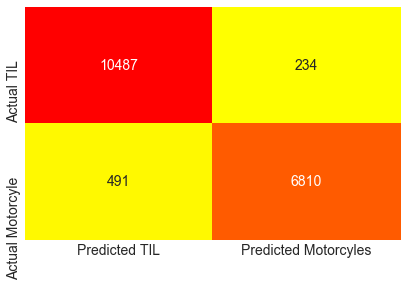

In [73]:
print(f"\033[1mTraining set confusion matrix\033[0m")
actual_v_predicted_train, confu_matrix = conf_matrix(gs_cvect_mn,X_clean_train,y_train)
plot_conf_matrix(confu_matrix,'afmhot_r');

print(f"\033[1mTesting set confusion matrix\033[0m")
actual_v_predicted_test,confu_matrix = conf_matrix(gs_cvect_mn,X_clean_test,y_test)
plot_conf_matrix(confu_matrix,'autumn_r');


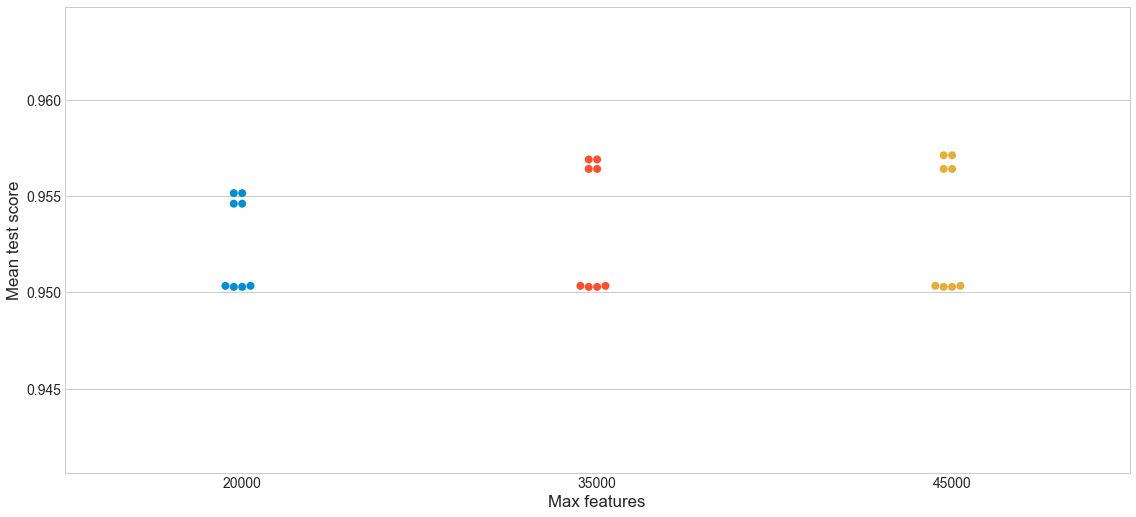

In [74]:
plot_cv_results(results_cvect_mn.param_countvectorizer__max_features,results_cvect_mn.mean_test_score)

In [75]:
pipette_tfidf_mn = make_pipeline(TfidfVectorizer(),MultinomialNB())

pipe_params_tfidf_mn = {
    'tfidfvectorizer__max_features': [35_000,45_000,55_000],
    'tfidfvectorizer__ngram_range': [ (1,2),(1,3)],
    'tfidfvectorizer__min_df' : [5, 10],
    'tfidfvectorizer__max_df' : [0.85, 0.95],
    'tfidfvectorizer__stop_words' : [None],
    'multinomialnb__alpha': [1]
}

gs_tfidf_mn = GridSearchCV(pipette_tfidf_mn,
                             pipe_params_tfidf_mn,
                             cv = 5, verbose = 1)

results_tfidf_mn,gs_tfidf_mn = fit_grid_search(gs_tfidf_mn,X_clean_train,y_train,X_clean_test,y_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  4.6min finished


Grid search accuracy for estimator multinomialnb transformer tfidfvectorizer : 

On training data is 0.9741459415140749
On test data is 0.9690378426367773
Grid search best score (avg of cv scores) 0.964006559169172


Model with best fitting parameter is 
 <bound method Pipeline.get_params of Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.85,
                                 max_features=35000, min_df=5,
                                 ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                

Training set confusion matrix


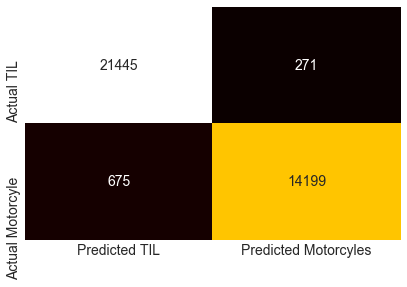

Testing set confusion matrix


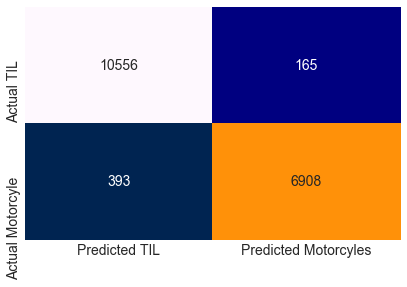

In [76]:
print(f"\033[1mTraining set confusion matrix\033[0m")
actual_v_predicted_train, confu_matrix = conf_matrix(gs_tfidf_mn,X_clean_train,y_train)
plot_conf_matrix(confu_matrix, 'hot');

print(f"\033[1mTesting set confusion matrix\033[0m")
actual_v_predicted_test,confu_matrix = conf_matrix(gs_tfidf_mn,X_clean_test,y_test)
plot_conf_matrix(confu_matrix,'gist_ncar');

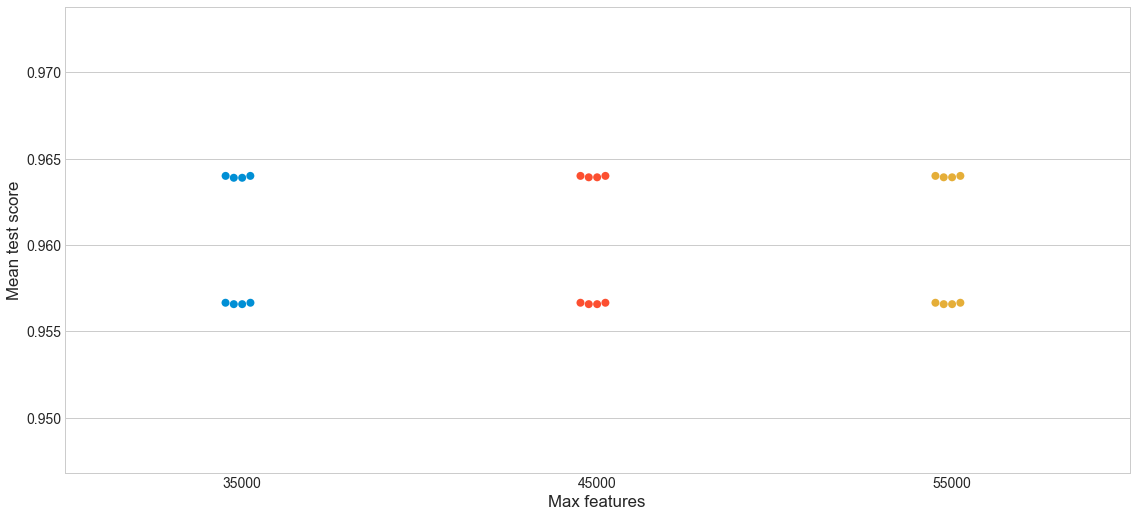

In [77]:
plot_cv_results(results_tfidf_mn.param_tfidfvectorizer__max_features,results_tfidf_mn.mean_test_score)

 ### Finally a simple decision tree modeled using raw data

In [78]:
cvect = CountVectorizer()
dtree_X_train = cvect.fit_transform(X_train).toarray()
dtree_X_test = cvect.transform(X_test).toarray()

In [79]:
dtree_X_train_df = pd.DataFrame(dtree_X_train)
dtree_X_test_df = pd.DataFrame(dtree_X_test)
dtree_X_test_df

,0,1,2,3,4,5,6,7,8,9,...,40418,40419,40420,40421,40422,40423,40424,40425,40426,40427
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18017,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18018,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18019,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18020,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [80]:
dtree = DecisionTreeClassifier(min_samples_split = 10, min_samples_leaf = 10,random_state = 42)

dtree.fit(dtree_X_train_df, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [81]:
dtree.score(dtree_X_train_df,y_train)
dtree.score(dtree_X_test_df,y_test)

0.9597430992074337

0.950726889357452

In [90]:
tree_prediction = dtree.predict(dtree_X_test_df)

In [91]:
type(tree_prediction)


numpy.ndarray

AttributeError: 'numpy.ndarray' object has no attribute 'count'

In [82]:
classnames = y.map({0 : 'TIL', 1: 'Motorcycle'})

export_graphviz(dtree,out_file  = "./predict.dot",class_names = classnames,
                feature_names = dtree_X_train_df.columns, rounded = True,filled = True, max_depth = 6
)